### 古典MD (GAFF2/AM1BCC力場）の実行とQEファイルの出力  
水32分子を25℃ (密度0.997)でNVTでMD計算    
1ナノ秒をdt = 0.2 fsで計算する。   
MDのカットオフ半径は4Å　長距離静電相互作用はPMEを使用。    
200fsで構造を出力し、最初の1,001フレームを捨てて4,000構造を出力する。    
ASEで構造を読み込んで、Quantum Espressoフォーマットで出力  

In [1]:
!rm -r -f input.acpype
!ls ./ |  grep -v -E 'inputs|Water_MD.ipynb' | xargs rm -rf 
!mkdir output

In [2]:
import pandas as pd
poly = pd.read_csv("./inputs/water.csv")
#poly = poly[1:].reset_index(drop=True)

In [3]:
poly

,Smiles,Name
0,O,SPCFW


In [4]:
max_atoms=32*3
density = 0.997062

dt = 0.2                           #[fs] MDの刻み時間：このまま使うことを推奨。
eq_temp = 25+273.15                #緩和計算させるときの温度 [K]
eq_steps = 5000000                 #緩和計算するstep数。この例だと1.0 nsec.
eq_cutoff = 4

!. /home/yamazaki/usr/local/gromacs/bin/GMXRC
gromacs_home = "/home/yamazaki/usr/local/gromacs/bin/"

In [5]:
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools

#化学構造のsmilesリストを準備する
smiles_list_polymer = poly["Smiles"].to_list()


# 化合物のラベルを作成
label_list = poly["Name"].to_list()

# molオブジェクトのリストを作成
mols_list_polymer = [Chem.MolFromSmiles(smile) for smile in smiles_list_polymer]

In [6]:
def gaff_bcc(smiles):
    #GAFF2/AM1-BCCをアサインする
    import sys,os,os.path
    os.environ['SMILES']=str(smiles)
    !echo ${SMILES} > input.smi
    !obabel -ismi input.smi -O input.mol2 --gen3D --conformer --nconf 5000 --weighted 
    !babel -imol2 input.mol2 -oxyz input.xyz
    from ase.io import read, write
    inp1 = read('input.xyz')
    !acpype -i input.mol2 -c bcc -n 0 -m 1 -a gaff2 -f -o gmx -k "qm_theory='AM1',grms_tol=0.05,scfconv=1.d-10,ndiis_attempts=700, "

    import shutil
    src = './input.acpype/input_GMX.gro'
    copy = './input1.gro'
    shutil.copyfile(src,copy)
    src = './input.acpype/input_GMX.itp'
    copy = './input1.itp'
    shutil.copyfile(src,copy)

In [7]:
gaff_bcc(smiles_list_polymer[0])

1 molecule converted
1 molecule converted
3 info messages 6 audit log messages 
| ACPYPE: AnteChamber PYthon Parser interfacE v. 2020-10-24T12:16:34CEST (c) 2021 AWSdS |
==> ... charge set to 0
==> Executing Antechamber...
==> * Antechamber OK *
==> * Parmchk OK *
==> Executing Tleap...
++++++++++start_quote+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Checking 'HOH'....
Checking parameters for unit 'HOH'.
Checking for bond parameters.
Checking for angle parameters.
Unit is OK.
++++++++++end_quote+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
==> * Tleap OK *
==> Removing temporary files...
==> Writing GROMACS files

==> Writing GMX dihedrals for GMX 4.5 and higher.

==> Writing pickle file input.pkl
Total time of execution: less than a second


In [8]:
#make mdp file for energy minimization
def make_mdp_em(cutoff):

    mdp_file = "em.mdp"
    cutoff_radius    = cutoff/10.0
    
    lines = [
    "; VARIOUS PREPROCESSING OPTIONS",
    ";title                    = Yo",
    ";cpp                      = /usr/bin/cpp",
    "include                  =", 
    "define                   =", 
    "    ",
    "; RUN CONTROL PARAMETERS",
    "integrator               = steep",
    "nsteps                   = 1000000",
    "emtol                    = 10",
    "emstep                   = 0.1",
    "nstlist                  = 1",
    "cutoff-scheme            = verlet",
    "vdw-type                 = cut-off",
    "rlist                    = {}".format(cutoff_radius),
    "rvdw                     = {}".format(cutoff_radius),
    "rcoulomb                 = {}".format(cutoff_radius),
    ]

    with open(mdp_file, mode='w') as f:
        f.write('\n'.join(lines))

In [9]:
#make mdp file for NVT run
def make_mdp_nvt(temp,steps,dt,cutoff):

    temperature      = temp
    simulation_steps = steps 
    time_step        = dt/1000.0  # ps
    cutoff_radius    = cutoff/10.0
    
    mdp_file = "run.mdp"

    lines = [
    "; VARIOUS PREPROCESSING OPTIONS",
    ";title                    = Yo",
    ";cpp                      = /usr/bin/cpp",
    "include                  =", 
    "define                   =", 
    "    ",
    "; RUN CONTROL PARAMETERS",
    "constraints              = none",
    "integrator               = md",
    "nsteps                   = {}".format(simulation_steps),
    "dt                       = {}".format(time_step),
    "nstlist                  = 1",
    "rlist                    = {}".format(cutoff_radius),
    "rvdw                     = {}".format(cutoff_radius),
    "rcoulomb                 = {}".format(cutoff_radius),
    "coulombtype              = pme",
    "cutoff-scheme            = verlet",
    "vdw-type                 = cut-off",        
    "tc-grps                  = system",
    "tau-t                    = 0.1",
    "gen-vel                  = yes",
    "gen-temp                 = {}".format(temperature),
    "ref-t                    = {}".format(temperature),
    "Pcoupl                   = no",
    "Tcoupl                    = v-rescale " ,
    "nstenergy                = 1000",
    "nstxout                  = 1000", 
    "nstfout                  = 1000",
    "DispCorr                 = EnerPres",
    ]

    with open(mdp_file, mode='w') as f:
        f.write('\n'.join(lines))

In [10]:
def build_initial_cell_gromacs(dt,eq_cutoff,eq_temp,eq_steps):

    import pandas as pd
    
    import time 
    init_time = time.time()
    
    dt = dt

    import MDAnalysis as mda
    from nglview.datafiles import PDB, XTC

    #混合溶液を作成
    import mdapackmol
    import numpy as np
    from ase import units
    import shutil

    # load individual molecule files
    mol1 = mda.Universe('input1.gro')
    #num_mols1 = 30
    total_mol = int(max_atoms/(mol1.atoms.n_atoms))
    num_mols1 = total_mol
    mw_mol1 = np.sum(mol1.atoms.masses)
    total_weight = num_mols1 * mw_mol1 
    
    # Determine side length of a box with the density of mixture 
    #L = 12.0 # Ang. unit 
    d = density / 1e24 # Density in g/Ang3 
    volume = (total_weight / units.mol) / d
    L = volume**(1.0/3.0)
    
    system = mdapackmol.packmol(
    [ mdapackmol.PackmolStructure(
    mol1, number=num_mols1,
    instructions=["inside box "+str(0)+"  "+str(0)+"  "+str(0)+ "  "+str(L)+"  "+str(L)+"  "+str(L)]),])

    system.atoms.write('mixture.gro')

    import os 
    os.environ['GMX_MAXBACKUP'] = '-1'

    # for gromacs-5 or later 
    commands = gromacs_home+"gmx_mpi editconf -f mixture.gro  -box "+ str(L/10.0)+"  "+str(L/10.0)+"  "+str(L/10.0) + "  " +" -o init.gro"

    import subprocess
    from subprocess import PIPE

    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout
    #print('STDOUT: {}'.format(output))

    #make top file for GAFF

    top_file = "system.top"
    mol_name1 = "input"
 
    lines = [
        "; input_GMX.top created by acpype (v: 2020-07-25T09:06:13CEST) on Fri Jul 31 07:59:08 2020",
        ";by acpype (v: 2020-07-25T09:06:13CEST) on Fri Jul 31 07:59:08 2020",
        "   ",
        "[ defaults ]",
        "; nbfunc        comb-rule       gen-pairs       fudgeLJ fudgeQQ",
        "1               2               yes             0.5     0.8333",
        "    ",
        "; Include input.itp topology", 
        "#include \"{}.itp\"".format("input1"),
        "    ",
        "[ system ]",
        "input",
        "     ",
        "[ molecules ]",
        "; Compound        nmols" ,
        mol_name1 + "          {} ".format(num_mols1), 
    ]
        
    with open(top_file, mode='w') as f:
        f.write('\n'.join(lines))

    # Energy minimization
    import os
    import subprocess
    from subprocess import PIPE
    
    print('Minimizing energy')
    
    os.environ['GMX_MAXBACKUP'] = '-1'

    make_mdp_em(eq_cutoff)

    #grompp
    os.environ['OMP_NUM_THREADS'] = '1'    
    commands = gromacs_home+"gmx_mpi grompp -f em.mdp -p system.top -c init.gro -o em.tpr -maxwarn 10 "
    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout

    #mdrun
    os.environ['OMP_NUM_THREADS'] = '1' 
    commands = gromacs_home+"gmx_mpi mdrun -s em.tpr -o em.trr -e em.edr -c em.gro -nb cpu"
    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout

    #Relax the geometry 
    print('Running dynamics :Equilibration')
  
    temp = eq_temp
    dt   = dt 
    steps = eq_steps
    make_mdp_nvt(temp,steps,dt,eq_cutoff)

    #grompp
    os.environ['OMP_NUM_THREADS'] = '1'    
    commands = gromacs_home+"gmx_mpi grompp -f run.mdp -p system.top -c em.gro -o eq.tpr -maxwarn 10 ".format(str(temp))
    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout

    #mdrun
    os.environ['OMP_NUM_THREADS'] = '6' 
    commands = gromacs_home+"gmx_mpi mdrun -s eq.tpr -o eq.trr -e eq.edr -c eq.gro -nb gpu"
    proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
    output = proc.stdout

    print("elapsed time= {} sec.".format(time.time()-init_time))

In [11]:
build_initial_cell_gromacs(dt,eq_cutoff,eq_temp,eq_steps)

/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/yamazaki/miniconda3/envs/openmm/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


Minimizing energy
Running dynamics :Equilibration
elapsed time= 428.99074053764343 sec.


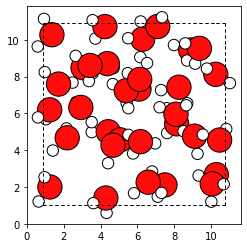

In [12]:
#構造可視化(matplotlib版)
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
import ase.io
mol1 = ase.io.read('eq.gro')
%matplotlib inline
plot_atoms(mol1, rotation=('0x,0y,0z'))
plt.show()

In [13]:
#構造可視化(nglview版)
import nglview as nv
import ase.io
mol1 = ase.io.read('eq.gro')
w = nv.show_ase(mol1)
w.add_label(radius=1,color="black",label_type="atom")
w.add_unitcell()
w.update_unitcell()
w

NGLWidget()

In [14]:
#Trajectoryの表示
import sys
import mdtraj

# ParmEd Imports
from parmed import load_file
from parmed.openmm.reporters import NetCDFReporter
from parmed import unit as u

#analysis
import os  
import subprocess
from subprocess import PIPE

!echo "System" > ./inputs/anal.txt 

commands = gromacs_home+"gmx_mpi trjconv -s eq.tpr -f eq.trr -dump 0 -o eq.pdb < ./inputs/anal.txt"
proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
output = proc.stdout
commands = gromacs_home+"gmx_mpi trjconv -s eq.tpr -f eq.trr -pbc atom -force -o eq_pbc.trr < ./inputs/anal.txt"
proc = subprocess.run(commands, shell=True, stdout=PIPE, stderr=PIPE,encoding='utf-8')
output = proc.stdout

traj=mdtraj.load("eq_pbc.trr", top="eq.pdb")
view=nv.show_mdtraj(traj,gui=True)
view.parameters =dict(
                        camera_type="orthographic",
                        backgraound_color="black",
                        clip_dist=0
)
view.clear_representations()
view.add_representation("ball+stick")
#view.add_representation("spacefill",selection=[i for i in range(n_atoms,n_total_atoms)],opacity=0.1)
view.add_unitcell()
view.update_unitcell()
view

NGLWidget(max_frame=5000)

In [15]:
#前半のトラジェクトリーのカットする
traj = traj[1001:]
len(traj)

4000

In [16]:
#トラジェクトリーをASEで読み込んでQuantumEspressoの入力ファイルを出力する
filename = "WAT"
for i,snapshot in enumerate(traj) :
    snapshot.save_gro("temp.gro")
    atoms1 = ase.io.read('temp.gro')
    atoms1.write("./output/"+filename+"_"+str(i)+".in",format="espresso-in")
    

In [ ]:
#ASEから直接QuantumEspressoを叩くことも可能

In [ ]:
from ase import Atoms
from ase.build import bulk 
from ase.calculators.espresso import Espresso 
pseudopotentials = {"H":"H.pbe-hgh.UPF","O":"O.pbe-hgh.UPF"}
input_data = { 
    "system": {
        "ecutwfc":100,
        "ecutrho":400,
        "occupations":"smearing",
        "smearing":"gauss",
        "degauss":0.01},
    "control":{
    "disk_io" : "low",
    "outdir"  : "./out",
    "pseudo_dir" : "./pseudo",
    "tprnfor" : True,
    "tstress" : True,
    }
}

calc = Espresso(pseudopotentials=pseudopotentials,kpts=(1,1,1),input_data=input_data)
atoms1.set_calculator(calc)

print(atoms1.get_potential_energy())
print(atoms1.get_forces())
!cat espresso.pwi
